A Bagging regressor.

A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

This algorithm encompasses several works from the literature. When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting [1]. If samples are drawn with replacement, then the method is known as Bagging [2]. When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces [3]. Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches [4].

source [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor)

In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

more [here](https://scikit-learn.org/stable/modules/ensemble.html#bagging)

In [1]:
# Need Time Consuming
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the Data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Bagging Regressor

In [9]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

In [10]:
class ModelEnsembleRegressors():

    def spe(self, y, y_pred): 
        return (y-y_pred)**2
        
    def train(self, df_train):

        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        self.models = {}
        spe_df = pd.DataFrame()
        
        self.to_predict_test = []
        
        for col in df_train.columns:
            
            model = BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
            tr_x = sklearn.preprocessing.scale(df_train.drop([col],axis=1))
            tr_y = sklearn.preprocessing.scale(df_train[col])
        
            model.fit(X=tr_x, y=tr_y)
            
            tr_y_pred = model.predict(X=tr_x)
            
            self.models[col] = model
                                    
            spe_df[col] = self.spe(tr_y, tr_y_pred)
            
            self.to_predict_test.append(col)           
                        
        return np.mean(spe_df, axis=1)
    
    def test(self, df_test):

        spe_df = pd.DataFrame()
        
        for col in self.to_predict_test:
            ts_x = np.array((df_test.drop([col],axis=1)-self.mu_train.drop([col]))/self.std_train.drop([col]))
            ts_y = np.array((df_test[col]-self.mu_train[col])/self.std_train[col])
            ts_y_pred = self.models[col].predict(ts_x)
            spe_df[col] = self.spe(ts_y, ts_y_pred)
                
        return np.mean(spe_df, axis=1)

# Noise filtering

In [11]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

# Training the Data

In [12]:
models = {'Bagging': ModelEnsembleRegressors()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

## Testing the Data

Bagging    49.91875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
Bagging,99.25,97.875,0.0,0.5,23.375,100.0,93.5,97.125,0.0,5.25,10.375,95.375,89.125,99.75,0.0,3.125,66.5,91.5,0.0,25.75


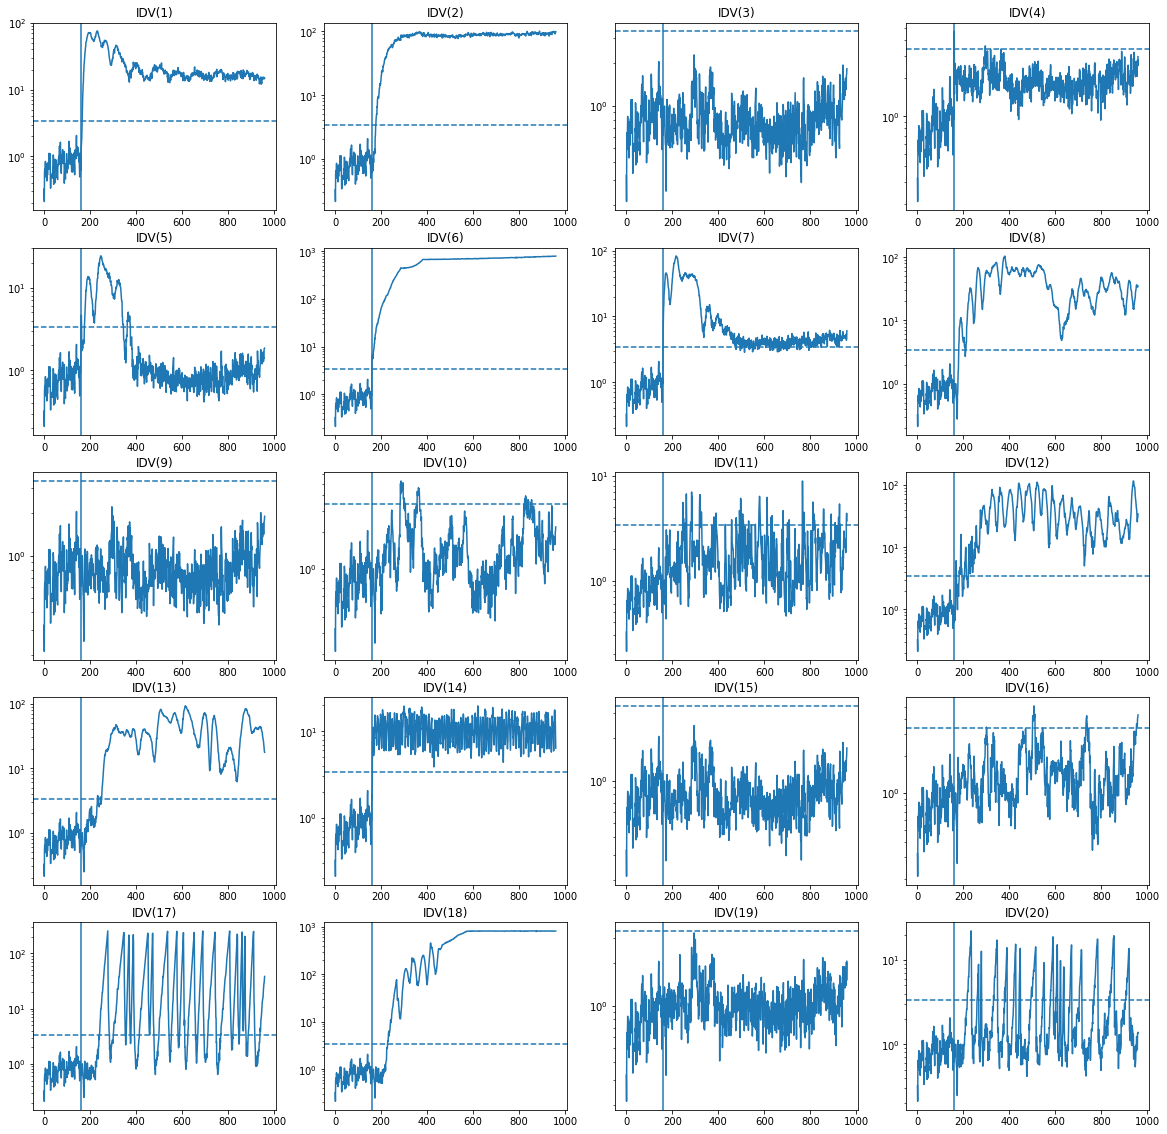

In [13]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

## Filter Noise

WS_10     52.83750
WS_50     53.04375
WS_100    58.31875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,98.875,97.75,0.0,99.375,26.000,99.500,99.625,97.00,0.0,5.250,45.125,96.75,90.500,0.5,0.0,1.625,80.500,91.875,0.0,26.500
WS_50,98.125,96.25,0.0,98.375,35.875,98.625,99.250,94.25,0.0,2.125,41.000,84.50,92.875,0.0,0.0,0.000,89.250,90.500,0.0,39.875
WS_100,98.000,95.50,0.0,98.125,96.750,98.500,99.000,94.00,0.0,0.000,43.250,82.25,90.625,0.0,0.0,0.000,89.375,90.000,0.0,91.000


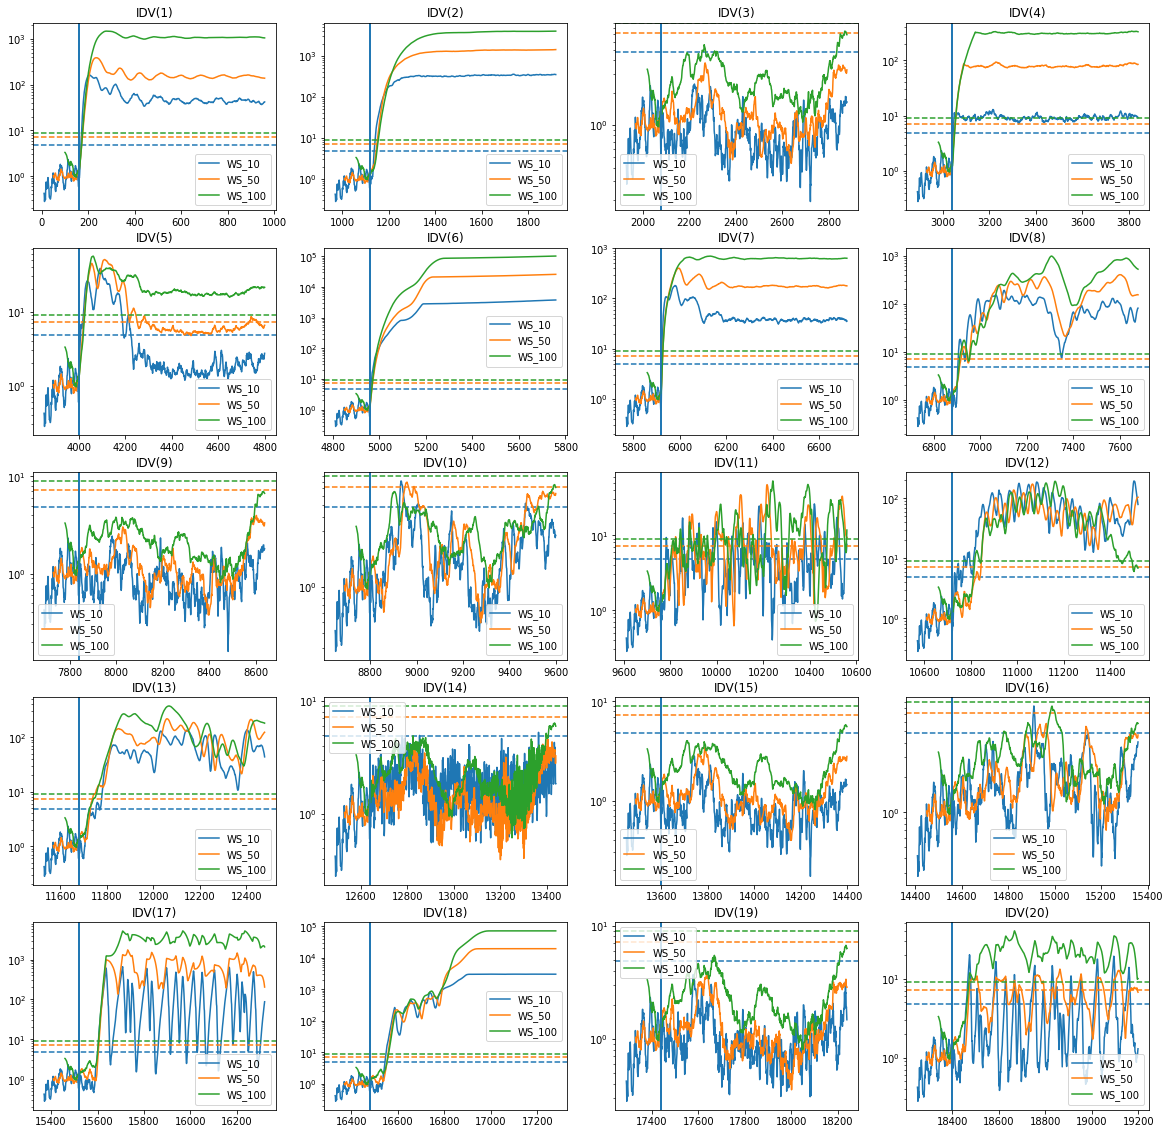

In [14]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelEnsembleRegressors(), 'WS_50': ModelEnsembleRegressors(), 'WS_100': ModelEnsembleRegressors()}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T